In [25]:
from kitti_util import *
from pylab import *
from plot_util import *
import ipywidgets as widgets
 
%matplotlib inline

# plt.rcParams["font.sans-serif"]=["Simhei"]#设置默认字体
# plt.rcParams["axes.unicode_minus"]=False#坐标轴正确显示正负号

发现pointpillars、second、parta2_free的对比结果比较明显，\
发现在dix=45、83、466即编号106、191、956上对比效果好，最终保存这三个的结果\
注意：图的比例大小为2：3，其中的位置可自己调节

In [26]:
def draw_image_point(img_id,kitti_path,file_path):
    path_img = kitti_path+"/image_2/%s.png"%img_id
    path_points =kitti_path+"/velodyne/%s.bin"%img_id   #点云
    points = np.fromfile(path_points, dtype=np.float32).reshape(-1, 4)#点云数据
    calib = Calibration(kitti_path+"/calib/%s.txt"%img_id) ## Path ## need to be changed
    df_label_2 = read_detection(kitti_path+"/label_2/%s.txt"%img_id)  #读取标签，可以选择过滤
    # print(df.head(5))#查看前5个标签
    # print(len(df_label_2))


    ##############   image   #####################
    image = cv2.imread(path_img)#读取数据
    # 绘制3dbox
    for o in range(len(df_label_2)):
        corners_3d_cam2 = compute_3d_box_cam2(*df_label_2.loc[o, ['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])
        pts_2d = calib.project_rect_to_image(corners_3d_cam2.T)
        image = draw_projected_box3d(image, pts_2d, color=(255,0,255), thickness=2)#(255,0,255)原始配色
    #绘制图像
    image_new = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,7))  # 打开一个画布
    plt.axis('off')  # 不打开坐标轴
    plt.tight_layout()
    plt.imshow(image_new)
    plt.savefig("./result/"+file_path+"/image_groud_truth.png")#保存
    plt.show()  # 加上这个才能显示


    ##############   points   #####################
    side_const=(-25, 15)#左右显示的范围，(-30, 30-0.05)为完整范围。
    fwd_const=(0, 60)#前后显示的范围，(-30, 60-0.05)为完整范围。一般只显示前半部分(0, 30)
    height_const=(-2, 2)#上下显示的范围,(-2, 2)为完整范围。
    box_color="fuchsia"#"box色彩，mediumspringgreen"绿色，"fuchsia"紫红色
    box_linewidth=2.5  #box线宽

    res_const=0.1 #res决定着点云的分辨率，越小分辨率越高，标准：0.07
    zres_const=2.0 #z方向的切片长度，决定在z方向的通道数。
    top = point_cloud_2_top(points, res=res_const,zres=zres_const, side_range=side_const, fwd_range=fwd_const,height_range=height_const)
    top = np.array(top, dtype = np.float32)
    print("热力图尺寸：",top.shape)#在z方向有多少通道取决于切片长度zres

    point_slices=top[:,:,0]#选择要显示的切片，0是下标，一般0即可，可以多尝试几个
    point_slices=np.where(point_slices>np.min(point_slices),0,1)#将切片二值化，大于min的为1，小于的为0，让图像更清晰。


    ##############   groud_truth   #####################
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    draw_2Dbox(df_=df_label_2 ,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/groud_truth.png")#保存
    plt.show()


    ##############   pointpillars  #####################
    pointpillars_path="./labels_zero/pointpillars"
    df_baseline = read_detection_pre(pointpillars_path+"/baseline/%s.txt"%img_id)  #读取标签，可以选择过滤
    df_fuzzy = read_detection_pre(pointpillars_path+"/fuzzy/%s.txt"%img_id)  #读取标签，可以选择过滤

    #######绘制baseline的结果
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    draw_2Dbox(df_=df_baseline ,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/pointpillar_b.png")#保存
    plt.show()

    #######绘制fuzzy的结果
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    #绘制2Dbox框图
    draw_2Dbox(df_=df_fuzzy,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/pointpillar_f.png")#保存
    plt.show()



    ##############   second  #####################
    pointpillars_path="./labels_zero/second"
    df_baseline = read_detection_pre(pointpillars_path+"/baseline/%s.txt"%img_id)  #读取标签，可以选择过滤
    df_fuzzy = read_detection_pre(pointpillars_path+"/fuzzy/%s.txt"%img_id)  #读取标签，可以选择过滤

    #######绘制baseline的结果
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    draw_2Dbox(df_=df_baseline ,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/second_b.png")#保存
    plt.show()


    #######绘制fuzzy的结果
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    #绘制2Dbox框图
    draw_2Dbox(df_=df_fuzzy,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/second_f.png")#保存
    plt.show()



    ##############   parta2_free  #####################
    pointpillars_path="./labels_zero/parta2_free"
    df_baseline = read_detection_pre(pointpillars_path+"/baseline/%s.txt"%img_id)  #读取标签，可以选择过滤
    df_fuzzy = read_detection_pre(pointpillars_path+"/fuzzy/%s.txt"%img_id)  #读取标签，可以选择过滤

    #######绘制baseline的结果
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    draw_2Dbox(df_=df_baseline ,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/parta2_free_b.png")#保存
    plt.show()

    #######绘制fuzzy的结果
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(point_slices, cmap=plt.cm.binary_r,aspect='equal') # binary为黑白色，加_r取反为白黑色，渐变色
    #绘制2Dbox框图
    draw_2Dbox(df_=df_fuzzy,calib_=calib,ax_=ax,res_const_=res_const ,side_const_=side_const ,
                fwd_const_=fwd_const ,box_linewidth_=box_linewidth ,box_color_=box_color)
    plt.axis('off')
    plt.tight_layout()#自动调整子图参数,使之填充整个图像区域
    plt.savefig("./result/"+file_path+"/parta2_free_f.png")#保存
    plt.show()


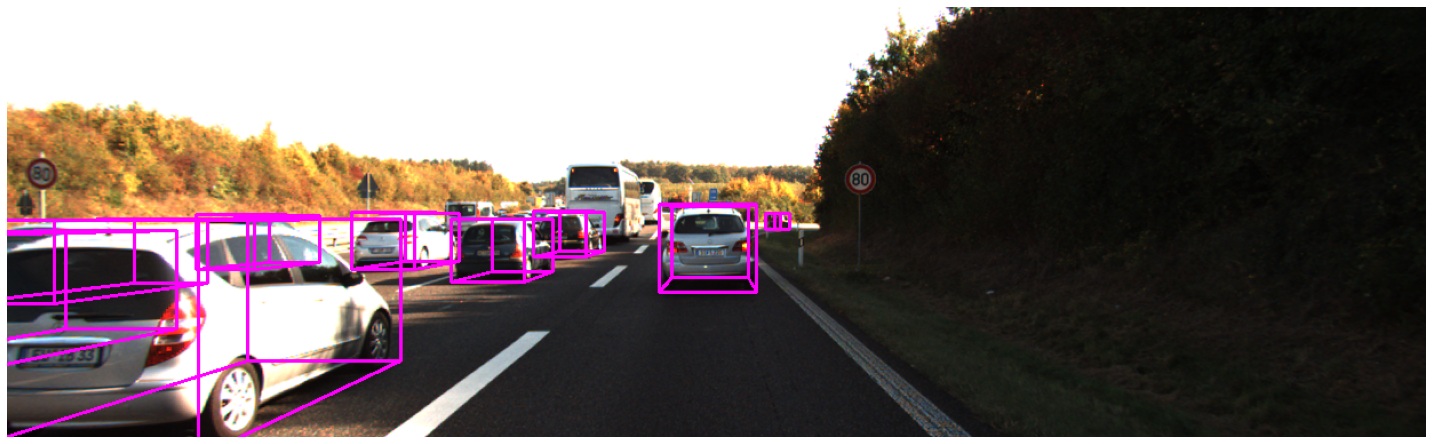

热力图尺寸： (601, 401, 3)


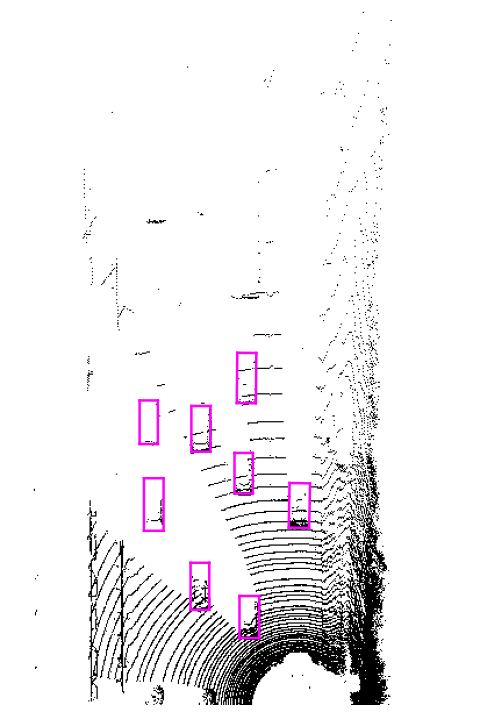

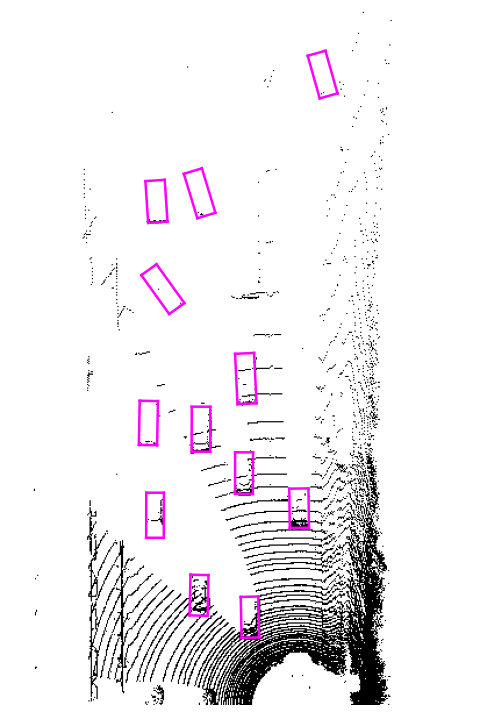

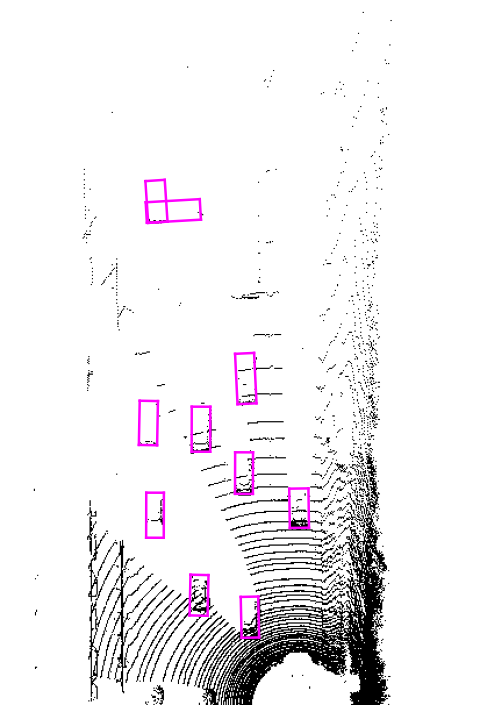

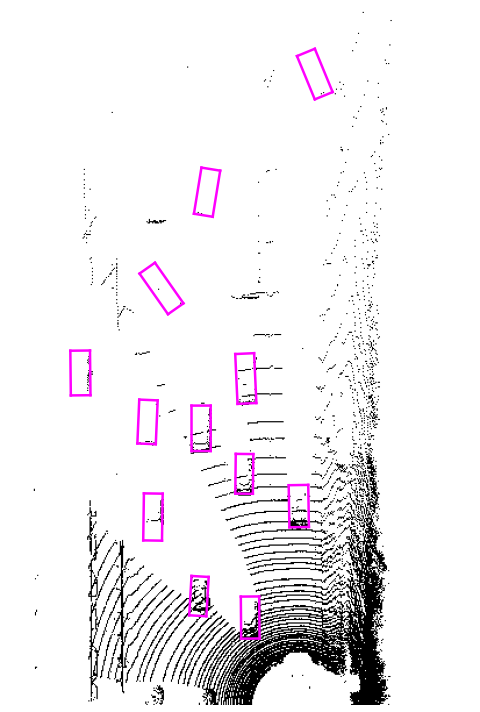

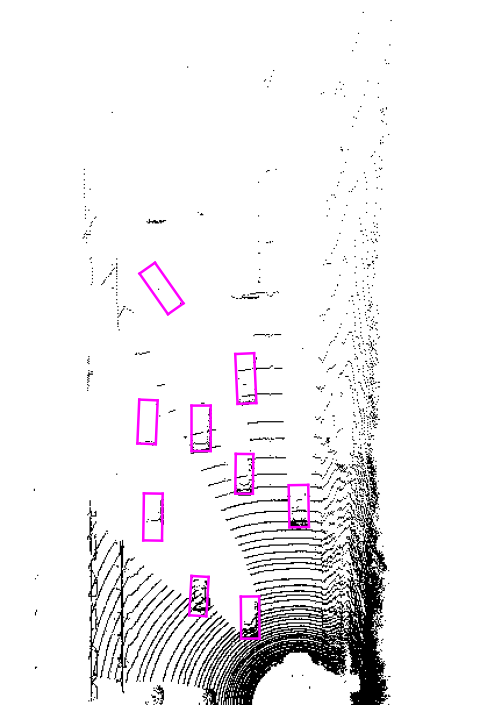

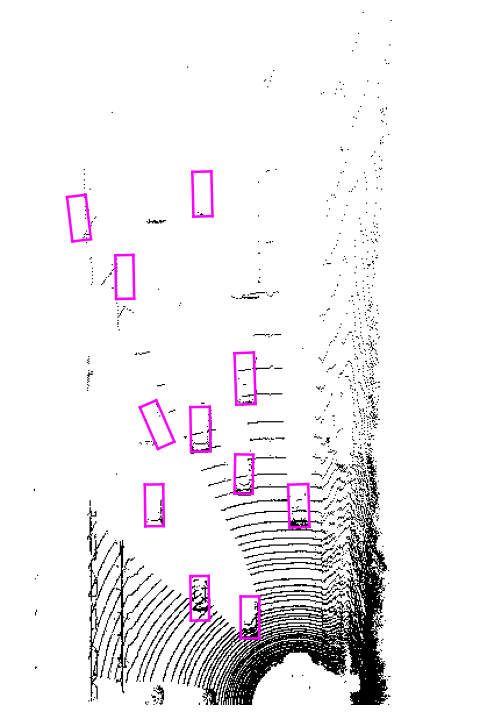

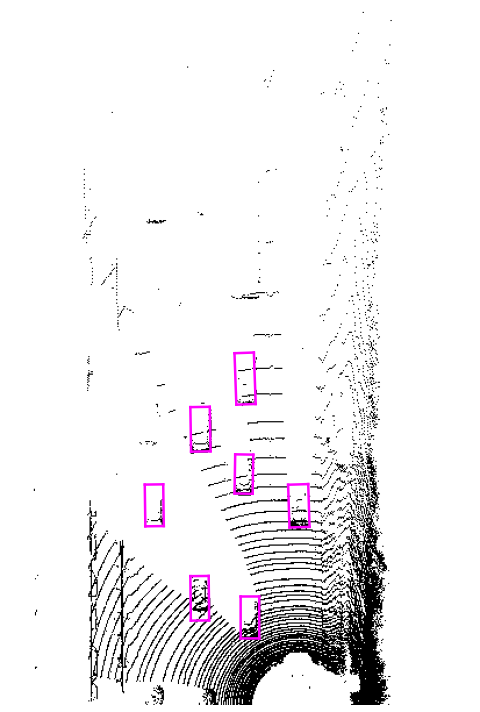

In [27]:
idx=466
#数据集路径
kitti_path_="/home/zhaofa/code/OpenPCDet/data/kitti/training"
# 读取val的文件索引
label_name = pd.read_csv('./labels_zero/val.txt',header=None,dtype=str)
img_id_=label_name[0].iloc[idx]
draw_image_point(img_id=img_id_,kitti_path=kitti_path_,file_path=img_id_)